## Parallel CNNs and RNNs

The goal is to train a CNN based classifier on the Mel spectrograms to predict the corresponding music genres.


In [66]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, concatenate, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Model

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
train_dataset = tf.data.Dataset.load('/content/drive/MyDrive/assign2_train')
val_dataset = tf.data.Dataset.load('/content/drive/MyDrive/assign2_val')

In [65]:
# pre-batch the data
batch_size = 128
train_dataset_batch = train_dataset.batch(batch_size)
val_dataset_batch = val_dataset.batch(batch_size)

for x_batch, y_batch in train_dataset_batch.take(1):
    print(x_batch.shape)

(128, 80, 80, 1)


In [49]:
for x, y in tf.data.Dataset.load('/content/drive/MyDrive/assign2_train').take(1):
    print(x.shape)
    print(y.shape)
    print(y)

(80, 80, 1)
(8,)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)


This show that we are working with one-hot encoded labels. This means that the true label (0 - 7) is represented by a vector with the 1 position corresponding to it's class. Because of this, we will use `categorical_crossentropy` as the loss function when we train the model.

We will use `softmax` as the activation function because the task is a multi-class classification problem with 8 possible music genres. `softmax` converts the output of the network into a probability distribution across these 8 classes, allowing the model to predict the most likely genre for each input.

In [67]:
input_layer = Input(shape=(80, 80, 1))

# first parallel branch:
branch1 = Conv2D(3, (8, 8), padding='same')(input_layer)
branch1 = LeakyReLU(alpha=0.3)(branch1)
branch1 = MaxPooling2D(pool_size=(4, 4))(branch1)
branch1 = Flatten()(branch1) # flattens the output
branch1 = Dropout(0.3)(branch1) # adding dropout to prevent overfitting

# second parallel branch:
branch2 = Conv2D(4, (4, 4), padding='same')(input_layer)
branch2 = LeakyReLU(alpha=0.3)(branch2)
branch2 = MaxPooling2D(pool_size=(2, 2))(branch2)
branch2 = Flatten()(branch2) # flattens the output
branch2 = Dropout(0.3)(branch2) # adding dropout to prevent overfitting

# merge branches:
merged = concatenate([branch1, branch2])

# output layer:
output = Dense(8, activation='softmax')(merged) # softmax activation

model = Model(inputs=input_layer, outputs=output)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [68]:
# compile the model:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # using stochastic gradient descent

As mentioned previously, we are using `categorical_crossentropy` as the loss funtion because we are working with one-hot labels.

In [69]:
# train the model on the batched datasets:
history = model.fit(train_dataset_batch, validation_data=val_dataset_batch, epochs=50)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 914ms/step - accuracy: 0.3638 - loss: 1.6902 - val_accuracy: 0.5233 - val_loss: 1.2656
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 952ms/step - accuracy: 0.5373 - loss: 1.2419 - val_accuracy: 0.5663 - val_loss: 1.1342
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 954ms/step - accuracy: 0.5969 - loss: 1.0972 - val_accuracy: 0.6004 - val_loss: 1.0509
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 903ms/step - accuracy: 0.6265 - loss: 1.0047 - val_accuracy: 0.6237 - val_loss: 1.0009
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 932ms/step - accuracy: 0.6592 - loss: 0.9155 - val_accuracy: 0.6538 - val_loss: 0.9425
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 865ms/step - accuracy: 0.6825 - loss: 0.8729 - val_accuracy: 0.6612 - val_loss: 0.9092
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 0.6991 - loss: 0.8294 - val_accuracy: 0.6729 - val_loss: 0.8887
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 864ms/step - accuracy: 0.7087 - loss: 0.7905 - val_accu

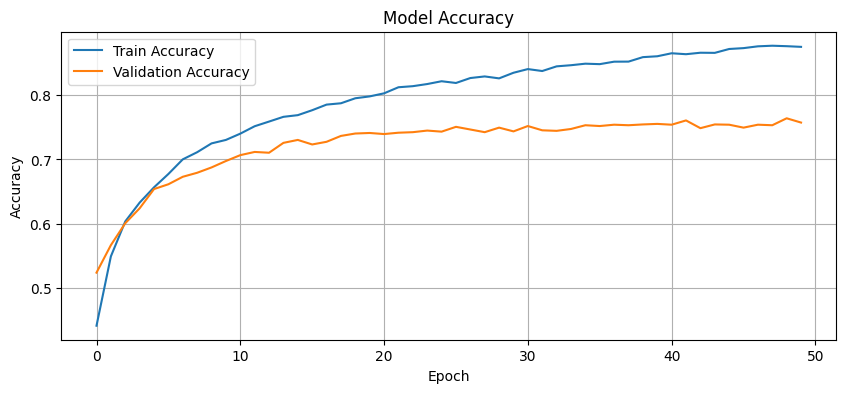

In [70]:
# accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


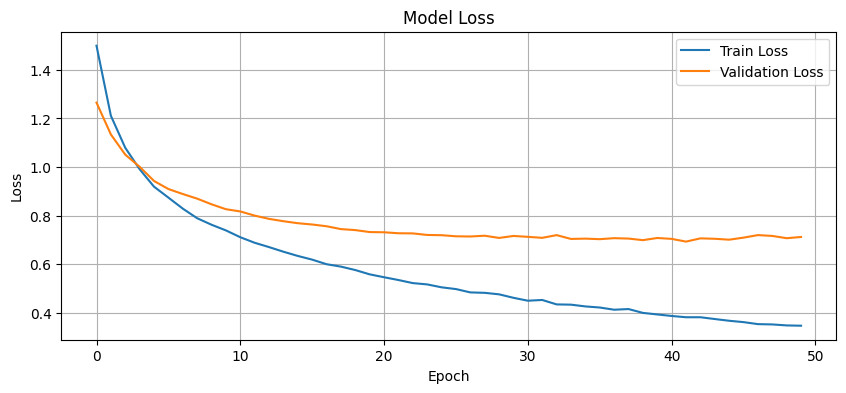

In [71]:
# loss plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_acc:.2%}")

Final Validation Accuracy: 75.75%


After training the parallel CNN model for 50 epochs, the final validation accuracy reached 69.13%, just below the 70% target. Adding the dropout term brought our accuracy up to 75.75% from 69.13%. This shows that the CNN was effective at learning relevant features from the Mel spectrograms for music genre classification.

**P1.2**
The goal is to train a CNN-RNN based classifier on the Mel spectrograms to predict the corresponding music genres

In [88]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

In [89]:
# reduce the imput dimensionality
def reduce_dimension(x, y):
    return tf.squeeze(x, axis=-1), y

train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze = val_dataset.map(reduce_dimension)

In [90]:
# batch the datasets
batch_size = 128
train_dataset_seq = train_dataset_squeeze.batch(batch_size)
val_dataset_seq = val_dataset_squeeze.batch(batch_size)

After applying `reduce_dimension`, the input shape changed from `(80, 80, 1)` to `(80, 80)`. This turned the spectrogram into a sequence, which works better for RNNs. Because of this, we will use `Conv1D` instead of `Conv2D` to work with the sequential format.

We will also use `softmax` in this part for the same reason as in P1.1 - `softmax` turns the output into class probabilities so it can predict one of 8 genres.

In [ ]:
# model
input_layer = Input(shape=(80, 80))

# CNN layers
x = Conv1D(8, kernel_size=4, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(6, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)

# RNN layers
x = LSTM(128, return_sequences=True)(x)
x = LSTM(32, return_sequences=False)(x)

# fully connected
x = Dense(200, activation='relu')(x)
x = Dropout(0.2)(x)

# output 
output = Dense(8, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

In [92]:
# compile the model:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

In [93]:
#train the model:
history = model.fit(train_dataset_seq, validation_data=val_dataset_seq, epochs=50)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.1674 - loss: 2.0576 - val_accuracy: 0.2488 - val_loss: 2.0237
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.2440 - loss: 2.0083 - val_accuracy: 0.2633 - val_loss: 1.9709
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.2532 - loss: 1.9502 - val_accuracy: 0.2800 - val_loss: 1.9219
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.2591 - loss: 1.8995 - val_accuracy: 0.2612 - val_loss: 1.8864
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.2752 - loss: 1.8651 - val_accuracy: 0.2621 - val_loss: 1.8602
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.2806 - loss: 1.8367 - val_accuracy: 0.2750 - val_loss: 1.8386
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.2994 - loss: 1.8182 - val_accuracy: 0.2879 - val_loss: 1.8195
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.3117 - loss: 1.8011 - val_accuracy

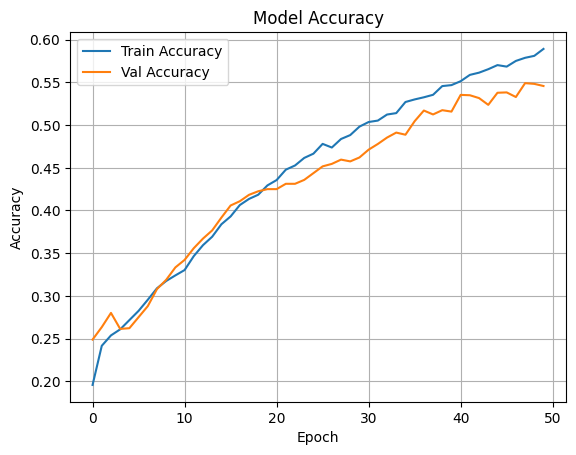

In [94]:
# accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

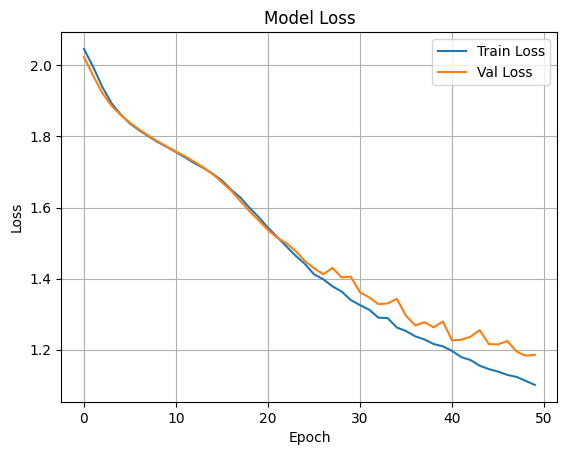

In [96]:
# loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")


Final Validation Accuracy: 54.58%


After training the CNN-RNN model for 50 epochs, we achieved a final validation accuracy of 54.58%, successfully exceeding the 50% requirement. This shows that the model was able to learn meaningful patterns from the spectrogram sequences to classify music genres.